## This notebook computes $P_{ge}(k)$, $P_{gg}(k)$ using the halo model

References:

 - **Code in this notebook is cut-and-paste from kSZquest:** https://github.com/alexlague/kSZquest/blob/main/prepare_gal_filter.py
 - Uses Mat's hmvec library: https://github.com/simonsobs/hmvec

This notebook writes two files:

  - Output file `pk_ge_gg.txt`: columns ($k$, $P_{ge}(k)$, $P_{gg}(k)$)
  - Output file `xl_ge_gg.txt`: columns ($l$, $X_l^{ge}$, $X_l^{gg}$), where $X_l^{ij} \equiv P_{ij}(k)_{k=l/\chi}$.

The second file is redundant but convenient. Note that $X_l$ is not an angular power spectrum -- it has units Mpc$^3$.

## Imports and global variables

In [1]:
# Note: kszx is not used in this notebook.
import hmvec as hm
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt

In [2]:
# File 'global_params.py' in current directory
import global_params

lmax = global_params.ksz_lmax
ks = global_params.hmodel_ks
ms = global_params.hmodel_ms
minz = global_params.hmodel_minz
maxz = global_params.hmodel_maxz
zeff = global_params.hmodel_zeff
ngal = global_params.hmodel_ngal

## Run hmvec calculations and plot $P_{ge}(k)$, $P_{gg}(k)$

In [3]:
%%time

hcos = hm.HaloModel([zeff],ks,ms=ms)
hcos.add_battaglia_profile("electron",family="AGN")
hcos.add_hod(name="g",ngal=np.asarray([ngal]))
bg = hcos.hods['g']['bg'][0]  # Note that bg is calculated given the ngal
hpge = hcos.get_power_1halo("g","electron") + hcos.get_power_2halo("g","electron")
hpggtot = hcos.get_power_1halo("g","g") + hcos.get_power_2halo("g","g") + 1./ngal

hpge = hpge[0]        # shape (1,1000) -> shape (1000,)
hpggtot = hpggtot[0]  # shape (1,1000) -> shape (1000,)
chieff = hcos.comoving_radial_distance(zeff)

Bisection search converged in  17  iterations.
CPU times: user 2min 9s, sys: 3.09 s, total: 2min 12s
Wall time: 7.49 s


/home/kmsmith/miniforge3/envs/kszx/lib/python3.12/site-packages/hmvec/fft.py:91: RuntimeWarning: invalid value encountered in divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]
/home/kmsmith/miniforge3/envs/kszx/lib/python3.12/site-packages/hmvec/hmvec.py:719: RuntimeWarning: invalid value encountered in divide
  ret = Ns**2./Nc


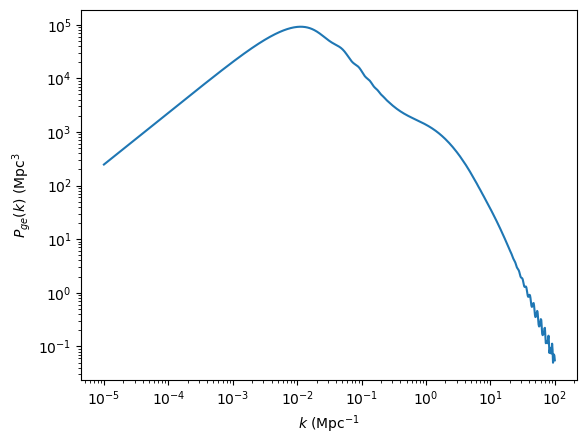

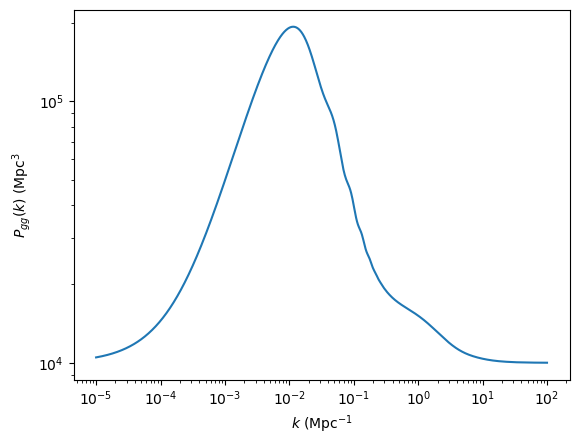

In [4]:
plt.plot(ks, hpge)
plt.xlabel(r'$k$ (Mpc$^{-1}$')
plt.ylabel(r'$P_{ge}(k)$ (Mpc$^3$')
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.plot(ks, hpggtot)
plt.xlabel(r'$k$ (Mpc$^{-1}$')
plt.ylabel(r'$P_{gg}(k)$ (Mpc$^3$')
plt.xscale('log')
plt.yscale('log')
plt.show()

## Compute and plot $X_l^{ge} \equiv P_{ge}(k)_{k=l/\chi}$ and $X_l^{gg} \equiv P_{gg}(k)_{k=l/\chi}$

In [5]:
# Interpolate log(k) -> P_ge(k)
# Interpolate log(k) -> P_gg(k)
interp_logk_pge = scipy.interpolate.InterpolatedUnivariateSpline(np.log(ks), hpge)
interp_logk_pgg = scipy.interpolate.InterpolatedUnivariateSpline(np.log(ks), hpggtot)

# X_l^{ge} = P_ge(k)_{k=l/chi_eff}
# X_l^{gg} = P_gg(k)_{k=l/chi_eff}

l = np.arange(lmax+1, dtype=float)
l[0] = 0.1   # avoid taking log(0)
logk = np.log(l/chieff)
xl_ge = interp_logk_pge(logk)
xl_gg = interp_logk_pgg(logk)

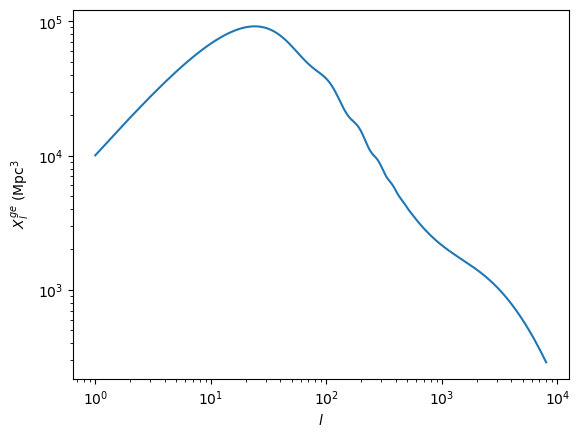

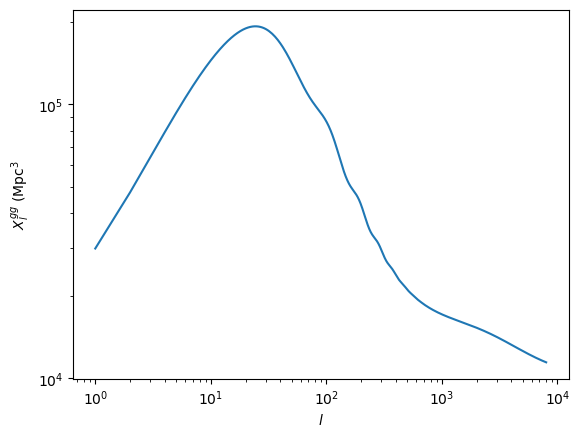

In [6]:
plt.plot(np.arange(1,lmax+1), xl_ge[1:])
plt.xlabel(r'$l$')
plt.ylabel(r'$X_l^{ge}$ (Mpc$^3$')
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.plot(np.arange(1,lmax+1), xl_gg[1:])
plt.xlabel(r'$l$')
plt.ylabel(r'$X_l^{gg}$ (Mpc$^3$')
plt.xscale('log')
plt.yscale('log')
plt.show()

## Write output files

In [7]:
np.savetxt(
    'pk_ge_gg.txt', 
    np.transpose([ks,hpge,hpggtot]),
    header = ('Col 0: k (Mpc^{-1})\n' +
              'Col 1: P_{ge}(k) (Mpc^3)\n' +
              'Col 2: P_{gg}^{tot}(k) (Mpc^3)\n')
)

np.savetxt(
    'xl_ge_gg.txt',
    np.transpose([np.arange(lmax+1), xl_ge, xl_gg]),
    header = ('Col 0: l\n' +
              'Col 1: X_l^{ge} (Mpc^3)\n' +
              'Col 2: X_l^{gg} (Mpc^3)\n' +
              'We define X_l^{ij} = P_{ij}(k)_{k=l/chi}\n' +
              'Note that X_l is not an angular power spectrum -- it has units Mpc^3\n')
)